In [1]:
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)
print(TORCH)
print(CUDA)

2.4.1
cu118


In [2]:
#Basic pre-reqs:

import torch


def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)


# !pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu118.html
# !pip install torch-geometric

import numpy as np
from torch.autograd import Variable
from matplotlib import pyplot as plt
import torch
from torch import nn
import math
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MessagePassing, global_max_pool
from torchvision import datasets, transforms
from torch_geometric.data import Data, DataLoader
import torch.utils.data as data_utils
import torch_geometric
from torch_scatter import scatter_max
import dataclasses
import networkx as nx
from typing import *
from tqdm import tqdm
import os
import jax
from scipy.integrate import odeint
from torch_geometric.nn import GCNConv
import copy

from torch_geometric.utils import add_self_loops, degree, remove_self_loops

NUM_EPOCHS = 20
LR = 5e-4
device = torch.device("cuda")
%matplotlib inline


## Training Utilities

In [3]:
@dataclasses.dataclass
class TrainResult:
    r"""
    A collection containing everything we need to know about the training results
    """

    num_epochs: int
    lr: float

    # The trained model
    model: nn.Module

    # Training loss (saved at each iteration in `train_epoch`)
    train_losses: List[float]

    # Training accuracies, before training and after each epoch
    train_accs: List[float]

    # Validation accuracies, before training and after each epoch
    val_accs: List[float]


def learning_curve(result: TrainResult, *, title: str = "Learning Curve"):
    r"""
    Plot the training loss, training accuracy, and validation accuracy versus
    epochs taken.
    """
    fig, ax_loss = plt.subplots(figsize=(8, 5))
    ax_loss.set_title(title, fontsize=16)
    ax_loss.set_xlabel("Epoch", fontsize=12)

    l_trloss = ax_loss.plot(
        torch.arange(len(result.train_losses))
        / len(result.train_losses)
        * result.num_epochs,
        result.train_losses,
        label="Train loss",
        color="C0",
    )
    ax_loss.set_ylim(0, max(result.train_losses))
    ax_loss.set_ylabel("Train loss", color="C0", fontsize=12)
    ax_loss.tick_params(axis="y", labelcolor="C0")

    ax_acc = ax_loss.twinx()
    if len(result.val_accs):
        l_valacc = ax_acc.plot(result.val_accs, label="Val", color="C1")
    else:
        l_valacc = ()
    ax_acc.set_ylim(0, max(max(result.val_accs), 1))
    ax_acc.set_ylabel("Validation", color="C1", fontsize=12)
    ax_acc.tick_params(axis="y", labelcolor="C1")

    lines = l_trloss + l_valacc

    ax_loss.legend(lines, [l.get_label() for l in lines], loc="upper left", fontsize=13)


def train_nn(
    model,
    train_dataset,
    test_dataset,
    batch_size=32,
    num_epochs=NUM_EPOCHS,
    lr=LR,
    graph=True,
    criterion=nn.CrossEntropyLoss(),
    regression=True,
):

    train_result = TrainResult(
        num_epochs, lr, model, train_losses=[], train_accs=[], val_accs=[]
    )

    if graph:
        train_loader = torch_geometric.loader.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )
        test_loader = torch_geometric.loader.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False
        )
    else:
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False
        )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    total_train = 0
    for epoch in range(num_epochs):

        model.train()
        for datapoint in tqdm(train_loader):
            if graph:
                datapoint = datapoint.to(device)
                X, y = datapoint, datapoint.y
            else:
                X, y = datapoint[0].to(device), datapoint[1].to(device)
            optimizer.zero_grad()
            output = model(X)

            loss = criterion(output, y)
            train_result.train_losses.append(loss.item())
            total_train += loss.item()
            loss.backward()
            optimizer.step()

        total_train = total_train / len(train_loader)

        model.eval()
        total_val = 0
        with torch.no_grad():
            for bidx, datapoint in enumerate(test_loader):
                if graph:
                    datapoint = datapoint.to(device)
                    X, y = datapoint, datapoint.y
                else:
                    X, y = datapoint[0].to(device), datapoint[1].to(device)
                output = model(X)
                if regression:
                    total_val += criterion(output, y).item()
                else:
                    total_val += torch.sum(
                        torch.argmax(output, dim=-1) == y
                    ).item() / output.size(dim=0)
        train_result.val_accs.append(total_val / len(test_loader))

        if regression:
            print(
                "Epoch {}: Train Loss={} Validation Loss={}".format(
                    epoch, total_train, train_result.val_accs[-1]
                )
            )
        else:
            print(
                "Epoch {}: Train Loss={} Validation Accuracy={}%".format(
                    epoch, total_train, train_result.val_accs[-1] * 100
                )
            )

    return train_result

## GNN Architecture

Graph neural networks subscribe to a slightly different API from [pytorch geometric](https://pytorch-geometric.readthedocs.io/en/latest/). In addition to the input features of shape [N, in_channels] for N nodes and `in_channels` node features per node, they also expect an edge_index tensor of shape [2, E] for E edges that specifies the *structure* of the graph.

Instead of sliding window convolutions used in the CNN, Graph neural networks use graph convolutions implemented via message passing. There are many ways to aggregate and normalize messages during graph convolutions. Here we will be using [Graph Convolutional Networks](https://arxiv.org/abs/1609.02907) (GCN).

GCNs normalize the messages by *both* the degrees from the source node and target node. More specifically, GCN message passing has the following form.

$$x_i^{(k)} = \sum_{j\in{\mathcal{N}(i)\cup{\{i\}}}}C\Big(W\cdot{x_j^{(k-1)}}\Big)+b$$


$$C=\frac{1}{\sqrt{\text{deg}(i)}\cdot\sqrt{\text{deg}(j)}}$$

Read the following code to see how a graph convolutional layer can be implemented. These layers are then interleaved with ReLU nonlinearities and then passed through `scatter_max` ([docs](https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/max.html)). Think about:
  - Why is `scatter_max` needed (Hint: try not including it and see what happens)?
  - How does `scatter_max` alter the shape of the activations

In [4]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr="add")
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)

        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)

        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        out = self.propagate(edge_index, x=x, norm=norm)
        out += self.bias

        return out

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j


class GNN(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=10):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 48)
        self.conv4 = GCNConv(48, 64)
        self.linear1 = torch.nn.Linear(64, 64)
        self.linear2 = torch.nn.Linear(64, out_channels)

    def forward(self, data):
        # Graph convolutional layers
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)

        # scatter_max
        x, _ = scatter_max(x, data.batch, dim=0)

        # linear
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

# Molecules

In this problem we will be trying to predict water solubility of a molecule from its chemical structure. The water solubility of a molecule is a measure of the amount of chemical substance that can dissolve in water at a specific temperature. The unit of  solubility is in mg/L.

Molecules can be represented in a graph structure in which the nodes are atoms and the edges are bonds between atoms or as an image in the form of a SMILES line notation. Both representations have the same information.

Fill in the rest of the code.

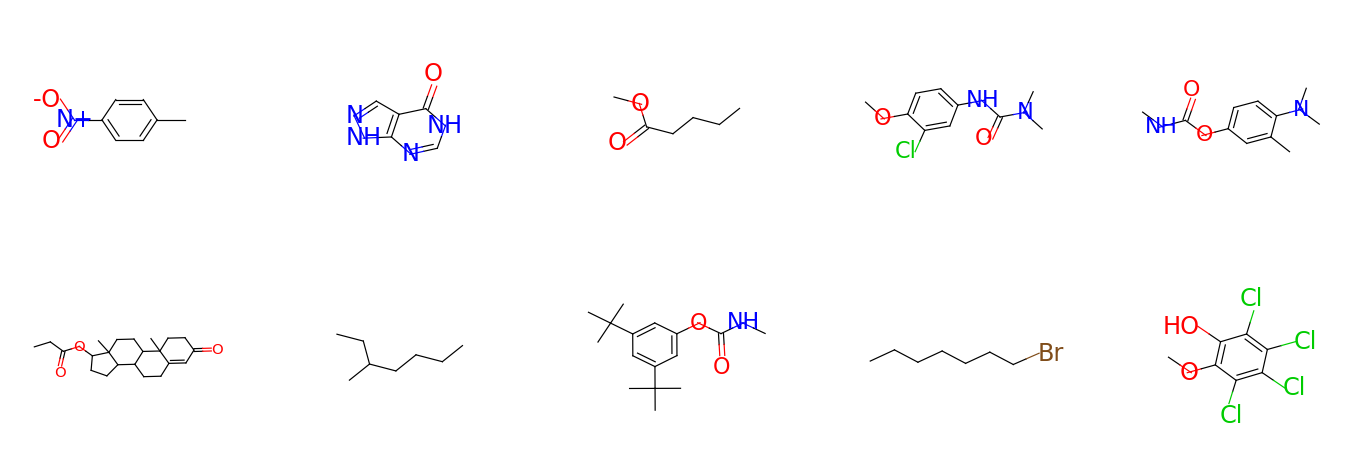

In [8]:
from torch_geometric.datasets import MoleculeNet
from torchdrug import data as tddata
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from IPython.display import clear_output

dataset = MoleculeNet(root="/tmp/ESOL", name="ESOL")
dataset = dataset.shuffle()

graph_dataset = []
image_dataset = []
data_els = []
for data_el in tqdm(dataset):
    try:
        mol = tddata.Molecule.from_smiles(data_el.smiles)
    except:
        continue

    fig = Figure(figsize=(2, 2))
    canvas = FigureCanvas(fig)
    ax = fig.gca()

    ax.axis("off")
    p = mol.visualize(ax=ax)
    canvas.draw()  # draw the canvas, cache the renderer

    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,)
    )

    plt.close(fig)
    plt.cla()
    plt.close("all")
    if data_el.x.shape[0] > 0:
        image_dataset.append(
            (
                torch.tensor(image_from_plot).type(torch.FloatTensor).permute(2, 0, 1),
                torch.squeeze(data_el.y),
            )
        )
        graph_dataset.append(
            Data(
                x=data_el.x.type(torch.FloatTensor),
                edge_index=data_el.edge_index,
                edge_attr=data_el.edge_attr,
                smiles=data_el.smiles,
                y=data_el.y,
            )
        )
        data_els.append(data_el)

num_train = 2 * len(graph_dataset) // 3

  0%|          | 0/1128 [00:00<?, ?it/s]C:\Users\moumo\AppData\Local\Temp\ipykernel_31100\2164274130.py:27: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
100%|██████████| 1128/1128 [00:33<00:00, 33.64it/s]


100%|██████████| 24/24 [00:01<00:00, 17.04it/s]


Epoch 0: Train Loss=13.402704854806265 Validation Loss=14.041149854660034


100%|██████████| 24/24 [00:00<00:00, 176.47it/s]


Epoch 1: Train Loss=11.079787955515917 Validation Loss=7.8187479972839355


100%|██████████| 24/24 [00:00<00:00, 176.48it/s]


Epoch 2: Train Loss=5.541143436640225 Validation Loss=4.333878258864085


100%|██████████| 24/24 [00:00<00:00, 186.05it/s]


Epoch 3: Train Loss=4.690108041771986 Validation Loss=4.333628952503204


100%|██████████| 24/24 [00:00<00:00, 180.45it/s]


Epoch 4: Train Loss=4.708872764508292 Validation Loss=4.28902421394984


100%|██████████| 24/24 [00:00<00:00, 185.96it/s]


Epoch 5: Train Loss=4.626000114993932 Validation Loss=4.33606477578481


100%|██████████| 24/24 [00:00<00:00, 187.51it/s]


Epoch 6: Train Loss=4.553141412996446 Validation Loss=4.229243298371633


100%|██████████| 24/24 [00:00<00:00, 188.98it/s]


Epoch 7: Train Loss=4.578653288295832 Validation Loss=4.261102696259816


100%|██████████| 24/24 [00:00<00:00, 183.21it/s]


Epoch 8: Train Loss=4.4959888835918145 Validation Loss=4.283772150675456


100%|██████████| 24/24 [00:00<00:00, 190.48it/s]


Epoch 9: Train Loss=4.507655572478023 Validation Loss=4.148170133431752


100%|██████████| 24/24 [00:00<00:00, 171.44it/s]


Epoch 10: Train Loss=4.427293258888194 Validation Loss=4.461428960164388


100%|██████████| 24/24 [00:00<00:00, 182.49it/s]


Epoch 11: Train Loss=4.442293383925436 Validation Loss=4.01798935731252


100%|██████████| 24/24 [00:00<00:00, 182.99it/s]


Epoch 12: Train Loss=4.327487333708723 Validation Loss=4.0819235642751055


100%|██████████| 24/24 [00:00<00:00, 188.98it/s]


Epoch 13: Train Loss=4.311218891876179 Validation Loss=4.248249292373657


100%|██████████| 24/24 [00:00<00:00, 173.81it/s]


Epoch 14: Train Loss=4.410241530766803 Validation Loss=3.976093610127767


100%|██████████| 24/24 [00:00<00:00, 189.89it/s]


Epoch 15: Train Loss=4.236488046183798 Validation Loss=3.944474776585897


100%|██████████| 24/24 [00:00<00:00, 193.55it/s]


Epoch 16: Train Loss=4.203515715977161 Validation Loss=3.834628780682882


100%|██████████| 24/24 [00:00<00:00, 196.04it/s]


Epoch 17: Train Loss=4.159694883044421 Validation Loss=3.793453335762024


100%|██████████| 24/24 [00:00<00:00, 183.21it/s]


Epoch 18: Train Loss=4.071118115253575 Validation Loss=3.7153520584106445


100%|██████████| 24/24 [00:00<00:00, 177.78it/s]


Epoch 19: Train Loss=4.013420134735907 Validation Loss=3.6526599327723184


100%|██████████| 24/24 [00:00<00:00, 186.00it/s]


Epoch 20: Train Loss=3.9541405551116005 Validation Loss=3.7077287435531616


100%|██████████| 24/24 [00:00<00:00, 186.05it/s]


Epoch 21: Train Loss=3.891747639048763 Validation Loss=3.531329651673635


100%|██████████| 24/24 [00:00<00:00, 179.11it/s]

Epoch 22: Train Loss=3.8707873492385225 Validation Loss=3.4972407519817352

100%|██████████| 24/24 [00:00<00:00, 184.62it/s]


Epoch 23: Train Loss=3.8337058361576055 Validation Loss=3.455119510491689


100%|██████████| 24/24 [00:00<00:00, 173.04it/s]


Epoch 24: Train Loss=3.769709335996898 Validation Loss=3.4511693517367044


100%|██████████| 24/24 [00:00<00:00, 177.78it/s]


Epoch 25: Train Loss=3.7430033976516044 Validation Loss=3.526020566622416


100%|██████████| 24/24 [00:00<00:00, 175.18it/s]

Epoch 26: Train Loss=3.7646752210734657 Validation Loss=3.327909141778946

100%|██████████| 24/24 [00:00<00:00, 158.94it/s]

Epoch 27: Train Loss=3.6471280936246053 Validation Loss=3.336812674999237



100%|██████████| 24/24 [00:00<00:00, 190.47it/s]


Epoch 28: Train Loss=3.628453065470875 Validation Loss=3.3918527166048684


100%|██████████| 24/24 [00:00<00:00, 171.43it/s]


Epoch 29: Train Loss=3.5603840371600466 Validation Loss=3.180689920981725


100%|██████████| 24/24 [00:00<00:00, 184.62it/s]


Epoch 30: Train Loss=3.489108483082022 Validation Loss=3.1994110445181527


100%|██████████| 24/24 [00:00<00:00, 180.45it/s]


Epoch 31: Train Loss=3.396305945188054 Validation Loss=3.1262601017951965


100%|██████████| 24/24 [00:00<00:00, 186.05it/s]


Epoch 32: Train Loss=3.332713898133497 Validation Loss=3.0280402104059854


100%|██████████| 24/24 [00:00<00:00, 172.66it/s]


Epoch 33: Train Loss=3.2189242316662963 Validation Loss=3.054180363814036


100%|██████████| 24/24 [00:00<00:00, 196.72it/s]


Epoch 34: Train Loss=3.192749354050307 Validation Loss=2.920280118783315


100%|██████████| 24/24 [00:00<00:00, 168.78it/s]


Epoch 35: Train Loss=3.139246169593837 Validation Loss=2.965324262777964


100%|██████████| 24/24 [00:00<00:00, 162.22it/s]

Epoch 36: Train Loss=3.068348181904476 Validation Loss=2.8258220553398132

100%|██████████| 24/24 [00:00<00:00, 181.82it/s]

Epoch 37: Train Loss=3.0171664461767143 Validation Loss=2.794514000415802



100%|██████████| 24/24 [00:00<00:00, 174.20it/s]

Epoch 38: Train Loss=2.924648873943734 Validation Loss=2.7199014921983085



100%|██████████| 24/24 [00:00<00:00, 178.54it/s]


Epoch 39: Train Loss=2.8102810975966626 Validation Loss=2.776929756005605


100%|██████████| 24/24 [00:00<00:00, 179.10it/s]


Epoch 40: Train Loss=2.7872493192431733 Validation Loss=2.6227877934773765


100%|██████████| 24/24 [00:00<00:00, 186.05it/s]


Epoch 41: Train Loss=2.714276497251778 Validation Loss=2.6084165573120117


100%|██████████| 24/24 [00:00<00:00, 182.92it/s]


Epoch 42: Train Loss=2.6868755198471654 Validation Loss=2.5479523340861


100%|██████████| 24/24 [00:00<00:00, 191.40it/s]


Epoch 43: Train Loss=2.5661942486007714 Validation Loss=2.580930769443512


100%|██████████| 24/24 [00:00<00:00, 171.29it/s]

Epoch 44: Train Loss=2.5484679967332204 Validation Loss=2.4778790374596915

100%|██████████| 24/24 [00:00<00:00, 163.26it/s]

Epoch 45: Train Loss=2.4986515890813883 Validation Loss=2.5603959560394287



100%|██████████| 24/24 [00:00<00:00, 177.78it/s]

Epoch 46: Train Loss=2.5551707829504253 Validation Loss=2.540749410788218



100%|██████████| 24/24 [00:00<00:00, 186.05it/s]


Epoch 47: Train Loss=2.4780072126350015 Validation Loss=2.7033168574174247


100%|██████████| 24/24 [00:00<00:00, 172.83it/s]

Epoch 48: Train Loss=2.506102100650309 Validation Loss=2.4459622701009116

100%|██████████| 24/24 [00:00<00:00, 187.50it/s]


Epoch 49: Train Loss=2.425567309709052 Validation Loss=2.48905419309934


100%|██████████| 24/24 [00:00<00:00, 188.98it/s]


Epoch 50: Train Loss=2.292437733902354 Validation Loss=2.407716612021128


100%|██████████| 24/24 [00:00<00:00, 181.18it/s]


Epoch 51: Train Loss=2.2806417421207583 Validation Loss=2.4147970179716745


100%|██████████| 24/24 [00:00<00:00, 181.82it/s]


Epoch 52: Train Loss=2.3342030722056237 Validation Loss=2.3719842632611594


100%|██████████| 24/24 [00:00<00:00, 191.34it/s]


Epoch 53: Train Loss=2.247564706033114 Validation Loss=2.263709247112274


100%|██████████| 24/24 [00:00<00:00, 192.00it/s]


Epoch 54: Train Loss=2.2052480492668702 Validation Loss=2.3484628399213157


100%|██████████| 24/24 [00:00<00:00, 192.00it/s]


Epoch 55: Train Loss=2.2532527368667945 Validation Loss=2.224321703116099


100%|██████████| 24/24 [00:00<00:00, 196.72it/s]


Epoch 56: Train Loss=2.197385814957334 Validation Loss=2.2871541182200112


100%|██████████| 24/24 [00:00<00:00, 196.42it/s]


Epoch 57: Train Loss=2.137483687333453 Validation Loss=2.1941464145978293


100%|██████████| 24/24 [00:00<00:00, 196.72it/s]


Epoch 58: Train Loss=2.0995656016440933 Validation Loss=2.151005278031031


100%|██████████| 24/24 [00:00<00:00, 200.00it/s]


Epoch 59: Train Loss=2.166242702814323 Validation Loss=2.1895422438780465


100%|██████████| 24/24 [00:00<00:00, 161.07it/s]


Epoch 60: Train Loss=2.069351488683471 Validation Loss=2.1324982047080994


100%|██████████| 24/24 [00:00<00:00, 152.08it/s]


Epoch 61: Train Loss=1.9749082572896386 Validation Loss=2.1339208583037057


100%|██████████| 24/24 [00:00<00:00, 172.35it/s]


Epoch 62: Train Loss=1.9994599829433657 Validation Loss=2.053694566090902


100%|██████████| 24/24 [00:00<00:00, 165.36it/s]


Epoch 63: Train Loss=2.0236084859003554 Validation Loss=2.207796881596247


100%|██████████| 24/24 [00:00<00:00, 167.83it/s]

Epoch 64: Train Loss=1.9726791994457027 Validation Loss=2.044764449199041

100%|██████████| 24/24 [00:00<00:00, 167.83it/s]

Epoch 65: Train Loss=1.91695285595409 Validation Loss=2.0114589234193168



100%|██████████| 24/24 [00:00<00:00, 181.82it/s]


Epoch 66: Train Loss=1.9482292461548216 Validation Loss=2.0192570785681405


100%|██████████| 24/24 [00:00<00:00, 172.58it/s]

Epoch 67: Train Loss=1.9027666024373389 Validation Loss=2.455569565296173

100%|██████████| 24/24 [00:00<00:00, 183.21it/s]

Epoch 68: Train Loss=2.0367292023864323 Validation Loss=2.294388920068741



100%|██████████| 24/24 [00:00<00:00, 167.83it/s]

Epoch 69: Train Loss=1.972796469335618 Validation Loss=2.018557141224543



100%|██████████| 24/24 [00:00<00:00, 179.10it/s]


Epoch 70: Train Loss=2.0138367004446214 Validation Loss=1.9535355071226757


100%|██████████| 24/24 [00:00<00:00, 184.62it/s]


Epoch 71: Train Loss=1.8734462194444903 Validation Loss=1.9196451902389526


100%|██████████| 24/24 [00:00<00:00, 165.31it/s]

Epoch 72: Train Loss=1.843246263484169 Validation Loss=1.9322410623232524



100%|██████████| 24/24 [00:00<00:00, 165.52it/s]

Epoch 73: Train Loss=1.808359729011026 Validation Loss=2.0669468144575753

100%|██████████| 24/24 [00:00<00:00, 151.82it/s]

Epoch 74: Train Loss=1.8280581155899156 Validation Loss=1.8848929007848103



100%|██████████| 24/24 [00:00<00:00, 167.83it/s]

Epoch 75: Train Loss=1.8330875433132174 Validation Loss=1.8798505862553914

100%|██████████| 24/24 [00:00<00:00, 167.83it/s]


Epoch 76: Train Loss=1.8056191743937016 Validation Loss=1.9284848769505818


100%|██████████| 24/24 [00:00<00:00, 167.83it/s]

Epoch 77: Train Loss=1.7652869793339192 Validation Loss=1.8564228117465973

100%|██████████| 24/24 [00:00<00:00, 173.81it/s]

Epoch 78: Train Loss=1.7129764431572774 Validation Loss=1.864092359940211



100%|██████████| 24/24 [00:00<00:00, 188.98it/s]

Epoch 79: Train Loss=1.6929657901072535 Validation Loss=1.8507148027420044



100%|██████████| 24/24 [00:00<00:00, 176.47it/s]


Epoch 80: Train Loss=1.7729882467320561 Validation Loss=1.7916343410809834


100%|██████████| 24/24 [00:00<00:00, 184.62it/s]


Epoch 81: Train Loss=1.8544549191516762 Validation Loss=1.784356524546941


100%|██████████| 24/24 [00:00<00:00, 179.10it/s]


Epoch 82: Train Loss=1.6447351096592104 Validation Loss=1.7718084454536438


100%|██████████| 24/24 [00:00<00:00, 158.49it/s]

Epoch 83: Train Loss=1.627486296488683 Validation Loss=1.8692071040471394

100%|██████████| 24/24 [00:00<00:00, 167.83it/s]

Epoch 84: Train Loss=1.716342417233265 Validation Loss=1.7572216788927715



100%|██████████| 24/24 [00:00<00:00, 156.64it/s]

Epoch 85: Train Loss=1.6250070518848414 Validation Loss=1.870533953110377



100%|██████████| 24/24 [00:00<00:00, 166.02it/s]

Epoch 86: Train Loss=1.693098153449583 Validation Loss=1.844837745030721

100%|██████████| 24/24 [00:00<00:00, 163.27it/s]

Epoch 87: Train Loss=1.6188331455728033 Validation Loss=1.7936292986075084



100%|██████████| 24/24 [00:00<00:00, 166.66it/s]

Epoch 88: Train Loss=1.7523075028042854 Validation Loss=1.757260948419571



100%|██████████| 24/24 [00:00<00:00, 170.21it/s]

Epoch 89: Train Loss=1.7106747241640292 Validation Loss=1.788236012061437

100%|██████████| 24/24 [00:00<00:00, 142.01it/s]


Epoch 90: Train Loss=1.7169399543430417 Validation Loss=1.7145826915899913


100%|██████████| 24/24 [00:00<00:00, 173.91it/s]


Epoch 91: Train Loss=1.755269111377605 Validation Loss=1.7776617308457692


100%|██████████| 24/24 [00:00<00:00, 171.43it/s]

Epoch 92: Train Loss=1.6091911520056676 Validation Loss=1.6591550707817078

100%|██████████| 24/24 [00:00<00:00, 172.66it/s]


Epoch 93: Train Loss=1.6068087084653175 Validation Loss=1.7767922828594844


100%|██████████| 24/24 [00:00<00:00, 153.62it/s]


Epoch 94: Train Loss=1.5551726340567162 Validation Loss=1.6577715973059337


100%|██████████| 24/24 [00:00<00:00, 158.94it/s]

Epoch 95: Train Loss=1.5270786687703393 Validation Loss=1.6639140745004017



100%|██████████| 24/24 [00:00<00:00, 165.52it/s]

Epoch 96: Train Loss=1.5203668144219928 Validation Loss=1.6608937283356984

100%|██████████| 24/24 [00:00<00:00, 160.00it/s]

Epoch 97: Train Loss=1.541190083932851 Validation Loss=1.7060559391975403

100%|██████████| 24/24 [00:00<00:00, 170.21it/s]

Epoch 98: Train Loss=1.6369503412028141 Validation Loss=1.6408361494541168



100%|██████████| 24/24 [00:00<00:00, 156.86it/s]

Epoch 99: Train Loss=1.6761791642895174 Validation Loss=1.6412564168373744

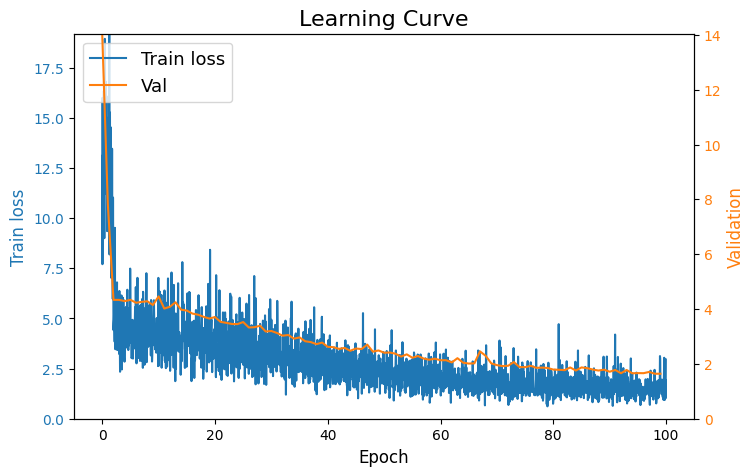

In [9]:
from rdkit.Chem import inchi
num_train = 2*len(graph_dataset)//3

train_dataset_tox = graph_dataset[:num_train]
test_dataset_tox = graph_dataset[num_train:]

# FIX ME: Instantiate the GNN model implemented above with 9 input channels, 1 output channel
model = GNN(in_channels=9,out_channels=1)
model.to(device)

# FIX ME: Train using train_nn method implemented above with the molecules dataset, learning rate 5e-4, MSE loss and for 100 epochs
gnn_molecule_results = train_nn(model=model,train_dataset=train_dataset_tox,test_dataset=test_dataset_tox,lr=5e-4,criterion=nn.MSELoss(),num_epochs=100)

%matplotlib inline
learning_curve(gnn_molecule_results)